In [12]:
import numpy as np
import random

from utils.blackjack_env_builder import BlackJackStylised
from utils.scorer import Scorer, quadratic_scorer
from tqdm import tqdm
from matplotlib import pyplot as plt
from utils.general import plot_Q_values

In [13]:
import numpy as np
import random

class BlackjackQLearningAgent:
    def __init__(self, num_states, num_deck_features, num_actions, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.Q = np.zeros((num_states, 2, num_actions)) ##np.zeros((num_states, 2, num_deck_features, num_actions))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.num_actions = num_actions

    def choose_action(self, state):
        current_sum, usable_ace, deck_feature = state
        if random.random() < self.epsilon:
            return random.choice(range(self.num_actions))
        else:
            ## return np.argmax(self.Q[int(current_sum), usable_ace, deck_feature])
            return np.argmax(self.Q[int(current_sum), usable_ace])

    def update(self, state, action, reward, next_state, done):
        current_sum, usable_ace, deck_feature = state
        next_sum, next_usable_ace, next_deck_feature = next_state

        ## old_value = self.Q[int(current_sum), usable_ace, deck_feature, action]
        old_value = self.Q[int(current_sum), usable_ace, action]
        # print(next_sum, next_usable_ace, next_deck_feature)
        ## next_max = np.max(self.Q[int(next_sum), next_usable_ace, next_deck_feature]) if not done else 0
        next_max = np.max(self.Q[int(next_sum), usable_ace]) if not done else 0

        new_value = old_value + self.learning_rate * (reward + self.discount_factor * next_max - old_value)
        self.Q[int(current_sum), usable_ace, action] = new_value

            
            

def get_deck_feature(card_counter):
    running_count = 0
    for card, info in card_counter.items():
        # print(f'card {card} info {info}')
        if card in ['2', '3', '4', '5', '6']:
            # print('cc', info['curr_count'])
            running_count += info['curr_count']
        elif card in ['10', 'J', 'Q', 'K', 'A']:
            # print('cc', info['curr_count'])
            running_count -= info['curr_count']

    # print('running count: ', running_count)
    if running_count <= -20:
        return 0  # Low count
    elif running_count <= 0:
        return 1  # Neutral
    else:
        return 2  # High count



In [14]:
# random.choice(range(2))

In [15]:
# Example usage
num_states = 22  # 1 to 21 for card sum, and an additional state for bust
num_deck_features = 3  # Categories: Low, Neutral, High
num_actions = 2  # Actions: 0 for stick, 1 for hit
discount_factor=0.95
epsilon = 1
min_epsilon = 0.05
max_epsilon = epsilon
decay_factor = 0.0005
agent = BlackjackQLearningAgent(num_states, num_deck_features, num_actions, discount_factor=discount_factor, epsilon=epsilon)

# Assuming you have an instance of your environment
env = BlackJackStylised(num_decks=3)

# assert 1==2
## cards, current_sum, usable_ace, hand_complete = env.reset_init(hard=True)
# print(cards, current_sum, usable_ace, hand_complete)
# print(env.card_counter)
max_episodes = 100000
for episode in tqdm(range(max_episodes)):
    cards, current_sum, usable_ace, hand_complete = env.reset_init(hard=True)
    # print(env.card_counter)
    deck_feature = get_deck_feature(env.card_counter)
    # print(deck_feature)
    state = (int(current_sum-1), int(usable_ace), deck_feature)
    # state = (int(current_sum), int(usable_ace), deck_feature)
    done = hand_complete
    agent.epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_factor*episode) 
    # print(agent.Q)

    
    while not env.deck_complete: ## 1 episode
        while not done: ## 1 Hand
            if env.deck_complete:
                break
            action = agent.choose_action(state)
            # print(action)
            next_cards, next_sum, next_usable_ace, hand_complete = env.step(action)
            # print(next_cards)
            next_deck_feature = get_deck_feature(env.card_counter)
            next_state = (next_sum, int(next_usable_ace), next_deck_feature)
            # reward = -1 if next_sum > 21 else 0  # Define your reward strategy
            reward = 0 if not hand_complete else quadratic_scorer(next_sum)
            # if hand_complete:
            #     print('Reward: ', reward) 
            # else:
            #     pass
            # print('Reward: ', reward)
            agent.update(state, action, reward, next_state, hand_complete)
            state = next_state
            done = hand_complete
            # print(state, done)
        
        # print('Hand Finished')
        cards, current_sum, usable_ace, hand_complete = env.reset_init()
    # print('Episode Complete')

# TODO: Check if required    
# for curr_sum in range(1,22):
#     for action in range(2):
#         if agent.Q[curr_sum, 1, action] == 0:
#             # print(agent.Q[curr_sum, 1, action], agent.Q[curr_sum, 0, action])
#             agent.Q[curr_sum, 1, action] = agent.Q[curr_sum, 0, action]
        


100%|██████████| 100000/100000 [00:22<00:00, 4416.82it/s]


In [16]:
# agent.Q

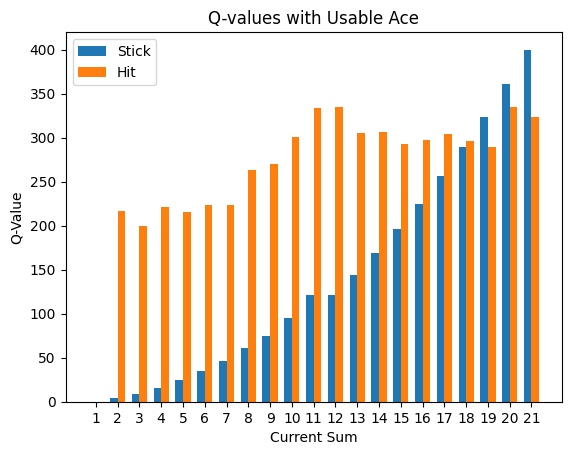

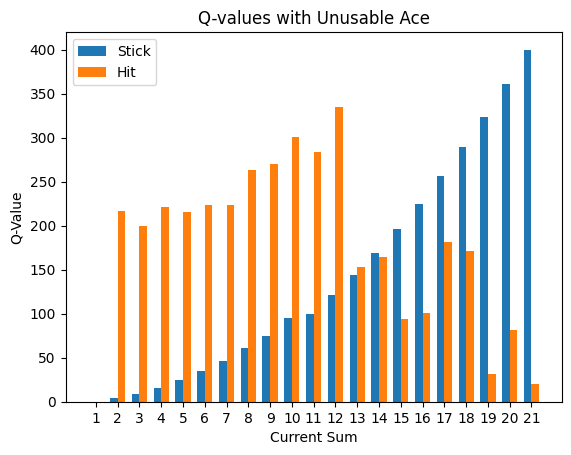

In [18]:
import matplotlib.pyplot as plt

def plot_q_values(agent, usable_ace, deck_feature_representative=0):
    x = range(1, 22)  # Assuming current_sum ranges from 1 to 21

    # q_stick = [agent.Q[sum_val - 1, int(usable_ace), deck_feature_representative, 0] for sum_val in x]
    # q_hit = [agent.Q[sum_val - 1, int(usable_ace), deck_feature_representative, 1] for sum_val in x]
    
    q_stick = [agent.Q[sum_val - 1, int(usable_ace), 0] for sum_val in x]
    q_hit = [agent.Q[sum_val - 1, int(usable_ace), 1] for sum_val in x]

    fig, ax = plt.subplots()

    bar_width = 0.35
    bar_stick = [i - bar_width / 2 for i in x]
    bar_hit = [i + bar_width / 2 for i in x]

    ax.bar(bar_stick, q_stick, bar_width, label='Stick')
    ax.bar(bar_hit, q_hit, bar_width, label='Hit')

    ax.set_xlabel('Current Sum')
    ax.set_ylabel('Q-Value')
    ax.set_title('Q-values with Usable Ace' if usable_ace else 'Q-values with Unusable Ace')
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.legend()

    plt.show()

plot_q_values(agent, usable_ace=True, deck_feature_representative=1)  # For usable ace
plot_q_values(agent, usable_ace=False, deck_feature_representative=1) # For unusable ace


In [9]:
def evaluate_agent(n_eval_episodes, Q):
  # Assuming you have an instance of your environment
  env = BlackJackStylised(num_decks=3)
  episode_rewards = []
#   print(Q)
  for episode in tqdm(range(n_eval_episodes)):
      total_rewards_ep = 0
      cards, current_sum, usable_ace, hand_complete = env.reset_init(hard=True)
      # print(env.card_counter)
      deck_feature = get_deck_feature(env.card_counter)
      # print(deck_feature)
      state = (int(current_sum-1), int(usable_ace), deck_feature)
      done = hand_complete

      
      while not env.deck_complete: ## 1 episode
          while not done: ## 1 Hand
              if env.deck_complete:
                  break
              # print(Q)
              # print(int(current_sum), usable_ace)
              # print(Q[int(current_sum), usable_ace])
              action = np.argmax(Q[int(current_sum-1), int(usable_ace)])
              # print(action)
              next_cards, next_sum, next_usable_ace, hand_complete = env.step(action)
              # print(next_cards)
              next_deck_feature = get_deck_feature(env.card_counter)
              next_state = (next_sum, int(next_usable_ace), next_deck_feature)
              reward = 0 if not hand_complete else quadratic_scorer(next_sum)
              if hand_complete:
                print(next_cards, next_sum, next_usable_ace)
                print('Reward: ', reward) 
              else:
                pass
              state = next_state
              current_sum = next_sum
              usable_ace = next_usable_ace 
              done = hand_complete
          
          # print('Hand Finished')
          cards, current_sum, usable_ace, hand_complete = env.reset_init()
      episode_rewards.append(reward)     
       
            
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward
  
evaluate_agent(n_eval_episodes=1000, Q=agent.Q)

init env


 40%|███▉      | 398/1000 [00:00<00:00, 3979.24it/s]

['H.7', 'D.5', 'D.5'] 17 False
Reward:  289
['C.10', 'S.2', 'S.9'] 21 False
Reward:  441
['S.5', 'H.J'] 15 False
Reward:  225
['C.A', 'D.3', 'D.2', 'H.A', 'D.10'] 17.0 False
Reward:  289.0
['S.9', 'H.6'] 15 False
Reward:  225
['H.9', 'D.A'] 20.0 True
Reward:  400.0
['S.4', 'D.10'] 14 False
Reward:  196
['C.6', 'C.3', 'S.6'] 15 False
Reward:  225
['H.J', 'S.4'] 14 False
Reward:  196
['H.J', 'D.9'] 19 False
Reward:  361
['D.3', 'C.A', 'C.9'] 13.0 False
Reward:  169.0
['D.8', 'D.J'] 18 False
Reward:  324
['C.J', 'S.2', 'H.9'] 21 False
Reward:  441
['D.9', 'H.A'] 20.0 True
Reward:  400.0
['S.A', 'C.A'] 12.0 True
Reward:  144.0
['H.8', 'C.8'] 16 False
Reward:  256
['H.J', 'D.4'] 14 False
Reward:  196
['D.10', 'C.Q'] 20 False
Reward:  400
['S.3', 'D.6', 'D.7'] 16 False
Reward:  256
['C.3', 'D.9', 'S.10'] 22 False
Reward:  0
['H.Q', 'D.K'] 20 False
Reward:  400
['S.3', 'C.J'] 13 False
Reward:  169
['H.A', 'D.10'] 21.0 True
Reward:  441.0
['D.A', 'H.6', 'C.J'] 17.0 False
Reward:  289.0
['D.8',

 83%|████████▎ | 827/1000 [00:00<00:00, 4161.39it/s]

['C.9', 'S.2', 'D.Q'] 21 False
Reward:  441
['C.J', 'D.A'] 21.0 True
Reward:  441.0
['S.5', 'H.5', 'C.K'] 20 False
Reward:  400
['H.Q', 'H.3'] 13 False
Reward:  169
['H.Q', 'C.A'] 21.0 True
Reward:  441.0
['D.7', 'H.5', 'C.6'] 18 False
Reward:  324
['H.6', 'H.9'] 15 False
Reward:  225
['H.5', 'S.4', 'D.K'] 19 False
Reward:  361
['H.Q', 'C.9'] 19 False
Reward:  361
['S.4', 'C.J'] 14 False
Reward:  196
['C.A', 'C.10'] 21.0 True
Reward:  441.0
['S.10', 'D.J'] 20 False
Reward:  400
['S.10', 'C.J'] 20 False
Reward:  400
['H.4', 'C.9'] 13 False
Reward:  169
['D.J', 'S.3'] 13 False
Reward:  169
['D.3', 'H.5', 'C.J'] 18 False
Reward:  324
['S.9', 'C.A'] 20.0 True
Reward:  400.0
['S.7', 'C.10'] 17 False
Reward:  289
['H.A', 'C.2', 'S.7'] 20.0 True
Reward:  400.0
['S.8', 'S.10'] 18 False
Reward:  324
['H.3', 'H.5', 'D.8'] 16 False
Reward:  256
['D.Q', 'C.K'] 20 False
Reward:  400
['D.K', 'C.7'] 17 False
Reward:  289
['C.4', 'H.5', 'H.2', 'H.Q'] 21 False
Reward:  441
['S.J', 'H.Q'] 20 False
Rewar

100%|██████████| 1000/1000 [00:00<00:00, 4148.66it/s]

['S.7', 'S.2', 'D.A'] 20.0 True
Reward:  400.0
['C.7', 'C.3', 'S.5'] 15 False
Reward:  225
['S.A', 'S.9'] 20.0 True
Reward:  400.0
['H.A', 'H.3', 'D.K'] 14.0 False
Reward:  196.0
['H.9', 'H.8'] 17 False
Reward:  289
['S.9', 'H.4'] 13 False
Reward:  169
['D.6', 'C.7'] 13 False
Reward:  169
['D.3', 'H.3', 'C.4', 'H.8'] 18 False
Reward:  324
['D.J', 'S.7'] 17 False
Reward:  289
['H.J', 'D.K'] 20 False
Reward:  400
['C.J', 'S.3'] 13 False
Reward:  169
['C.2', 'D.J', 'S.6'] 18 False
Reward:  324
['C.A', 'H.6', 'S.10'] 17.0 False
Reward:  289.0
['H.9', 'D.4'] 13 False
Reward:  169
['S.6', 'S.2', 'H.8'] 16 False
Reward:  256
['D.6', 'H.4', 'C.5'] 15 False
Reward:  225
['S.A', 'C.10'] 21.0 True
Reward:  441.0
['D.A', 'D.A'] 12.0 True
Reward:  144.0
['D.9', 'C.6'] 15 False
Reward:  225
['D.8', 'S.5'] 13 False
Reward:  169
['H.8', 'D.2', 'S.10'] 20 False
Reward:  400
['C.A', 'C.2', 'S.8'] 21.0 True
Reward:  441.0
['S.J', 'D.5'] 15 False
Reward:  225
['H.2', 'H.4', 'D.Q'] 16 False
Reward:  256
['

(282.903, 102.49838823610838)

In [7]:
def plot_Q_values_(q_values):
    # q_values is now a 2D numpy array, with shape (num_states, num_actions)
    
    num_states = q_values.shape[0]
    num_actions = q_values.shape[1]
    
    all_values_0 = q_values[:,0]
    all_values_1 = q_values[:,1]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 5))  
    width = 0.35 
    x = np.arange(num_states)  
    rects1 = ax.bar(x, all_values_0, width, label='Stick')  
    rects2 = ax.bar(x + width, all_values_1, width, label='Hit')

    ax.set_xlabel('State')
    ax.set_ylabel('Q-values') 
    ax.set_title('Q-values for Each State-Action Pair')
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(np.arange(num_states))
    legend_labels = ['Stick', 'Hit']
    ax.legend([rects1, rects2], legend_labels)

    plt.show()
    
# plot_Q_values_(agent.Q)

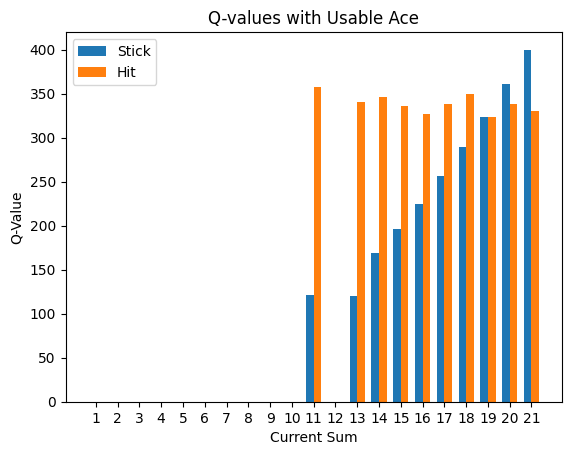

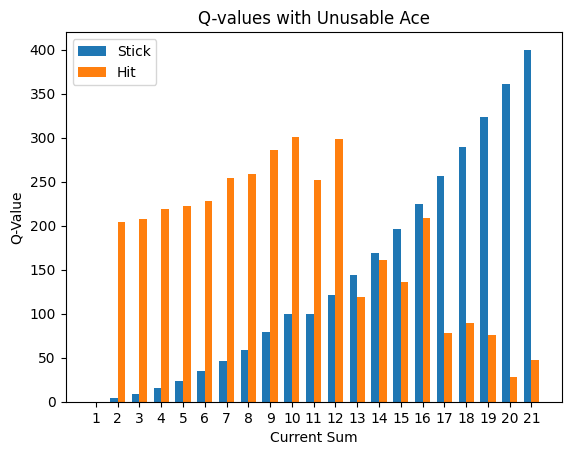

In [8]:
plot_q_values(agent, usable_ace=True, deck_feature_representative=1)  # For usable ace
plot_q_values(agent, usable_ace=False, deck_feature_representative=1) # For unusable ace

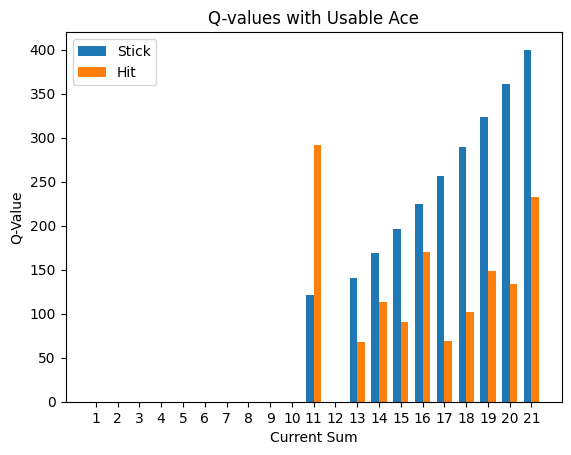

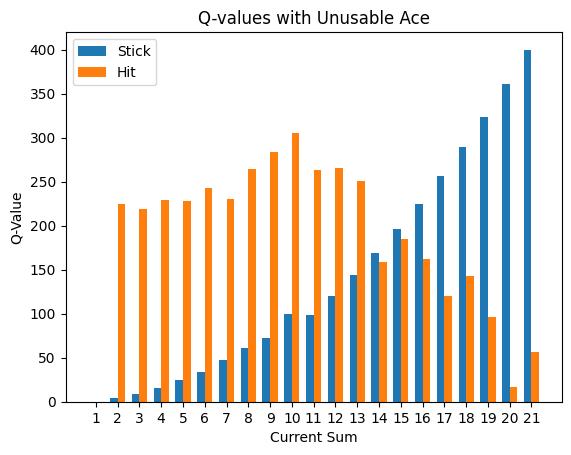

In [9]:
plot_q_values(agent, usable_ace=True, deck_feature_representative=2)  # For usable ace
plot_q_values(agent, usable_ace=False, deck_feature_representative=2) # For unusable ace

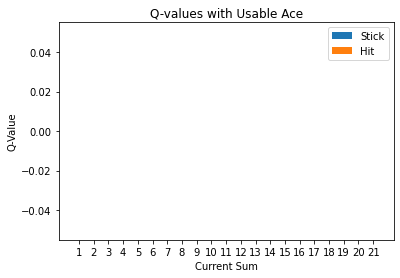

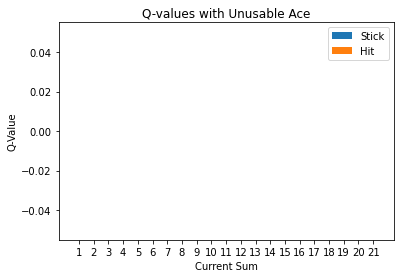

In [68]:
plot_q_values(agent, usable_ace=True, deck_feature_representative=0)  # For usable ace
plot_q_values(agent, usable_ace=False, deck_feature_representative=0) # For unusable ace

In [ ]:
plot_q_values(agent, usable_ace=True, deck_feature_representative=1)  # For usable ace
plot_q_values(agent, usable_ace=False, deck_feature_representative=1) # For unusable ace

In [69]:
agent.Q.shape

(22, 2, 3, 2)